**Tensorboard**[https://www.tensorflow.org/tensorboard] is a visualization and tooling for Tensorflow.

Tensorboard usually lives in the same directory of Python binary.

`KMP_DUPLICATE_LIB_OK` is sometimes needed when you have mixed OpenMP lib (e.g. MKL and libgomp)

In [1]:
%load_ext tensorboard

In [2]:
# Some environmental preparation
from pathlib import Path
import os
import sys
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ['TENSORBOARD_BINARY'] = str(Path(sys.executable).parent / "tensorboard")
try:
    import util
except ImportError:
    # Modify this according to your local env
    _src_root = Path.home() / "imageqc-master"
    sys.path.append(str(_src_root))
    import util


In [3]:
# System libraries
import matplotlib.pyplot as plt
import numpy; np = numpy  # Personal preference.
import datetime

In [4]:
# ML libraries
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam

# No surprise settings
tensorflow.random.set_seed(1)

# Graphviz is needed to plot model architecture
# from tensorflow.keras.utils import plot_model

In [5]:
# Initialize global variables
util.inject_config()
print(f"Project directory is {HOME_DIR}") 
print(f"Training set is in {TRAIN_DIR}") 
print(f"Validation(dev) set is in {VALIDATION_DIR}")
print(f"Evaluation(test) set is in {TEST_DIR}") 
print(f"Input image format is {EXTENSION}")

Project directory is /Users/jytang/imageqc-master
Training set is in /Users/jytang/imageqc-master/train_images
Validation(dev) set is in /Users/jytang/imageqc-master/validation_images
Evaluation(test) set is in /Users/jytang/imageqc-master/test_images
Input image format is .png


### Load training set with their labels

Reuse cached array train_cache.npz


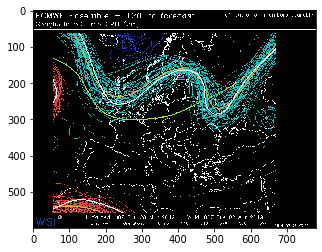

In [6]:
x_train, y_train = util.read_image("train", EXTENSION, onehot=True)
plt.imshow(x_train[0, :, :, :])

### Load dev set (validation images) and labels

In [7]:
x_validation, y_validation = util.read_image("validation", EXTENSION, onehot=True)

Reuse cached array validation_cache.npz


### Load test set (evaluation images) and labels

In [8]:
x_test, y_test = util.read_image("test", EXTENSION, onehot=True)

Reuse cached array test_cache.npz


### Create the VGG-like model, using Keras style

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=2, activation='relu', input_shape=(600, 780, 3)))
model.add(Conv2D(32, (3, 3), strides=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), strides=2, activation='relu'))
model.add(Conv2D(64, (3, 3), strides=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # two categories
model.summary()
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 389, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 149, 194, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 97, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 97, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 48, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 23, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 11, 64)         0

### Set up tensorboard to read training logs

In [10]:
log_dir = HOME_DIR / "logs" / "fit" / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=str(log_dir), histogram_freq=1)

### Training

In [11]:
history = model.fit(x_train, y_train, batch_size=16, epochs=10, validation_data=(x_validation, y_validation), callbacks=[tensorboard_callback])

Train on 740 samples, validate on 170 samples
Epoch 1/10
740/740 [==============================] - 55s 74ms/sample - loss: 0.8375 - accuracy: 0.9311 - val_loss: 0.0986 - val_accuracy: 0.9529
Epoch 2/10
740/740 [==============================] - 51s 69ms/sample - loss: 0.1653 - accuracy: 0.9392 - val_loss: 0.1094 - val_accuracy: 0.9529
Epoch 3/10
740/740 [==============================] - 52s 70ms/sample - loss: 0.0758 - accuracy: 0.9514 - val_loss: 0.0393 - val_accuracy: 0.9882
Epoch 4/10
740/740 [==============================] - 52s 70ms/sample - loss: 0.0976 - accuracy: 0.9689 - val_loss: 0.0519 - val_accuracy: 0.9529
Epoch 5/10
740/740 [==============================] - 52s 70ms/sample - loss: 0.1469 - accuracy: 0.9784 - val_loss: 0.0277 - val_accuracy: 1.0000
Epoch 6/10
740/740 [==============================] - 51s 70ms/sample - loss: 0.0295 - accuracy: 0.9919 - val_loss: 0.0149 - val_accuracy: 1.0000
Epoch 7/10
740/740 [==============================] - 51s 69ms/sample - loss: 

### Evaluation

In [12]:
score = model.evaluate(x_test, y_test, batch_size=10)
print('Model Score:', score)

170/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [13]:
# Write the model, weights and history to files
os.chdir(HOME_DIR)
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5") # serialize weights to HDF5

In [14]:
%tensorboard --logdir {log_dir}